# 0.0 IMPORTS

In [1]:
# Importing libs

import numpy  as np
import pandas as pd
import warnings 

from datetime import datetime

import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gs

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from boruta import BorutaPy

from sklearn import svm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from IPython.display       import Image
from IPython.core.display  import HTML

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 10]

    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

In [3]:
jupyter_settings()

## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('heart.csv')

In [5]:
df_raw.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# 1.0 DATA DESCRIBE

In [6]:
df1 = df_raw.copy()

Fonte: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## 1.1 Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 918
Number of columns: 12


## 1.2 Data types

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## 1.3 Check NA (%)

In [9]:
df_na = df1.isna().sum().sort_values(ascending=False)/df1.shape[0]*100
df_na

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64

## 1.4 Check Duplicates

In [10]:
df1.duplicated().sum()

0

## 1.5 Analisys columns

In [11]:
df1.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

# 2.0 EXPLORATORY ANALISYS - EDA

In [12]:
df2 = df1.copy()

In [13]:
num_attributes = df2.select_dtypes(include=['int64', 'float64'])
cat_attributes = df2.select_dtypes(exclude=['int64', 'float64'])

## 2.1 Statistic analisys

### 2.1.1 Response Variable

In [14]:
df2['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

### 2.1.2 Numerical Variable

In [15]:
# Tendência central - média e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - desvio padrão, min, max, assimetria, curtose
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Age,28.0,77.0,49.0,53.510893,54.0,9.427478,-0.195933,-0.386140
1,RestingBP,0.0,200.0,200.0,132.396514,130.0,18.504067,0.179839,3.271251
2,Cholesterol,0.0,603.0,603.0,198.799564,223.0,109.324551,-0.610086,0.118208
3,FastingBS,0.0,1.0,1.0,0.233115,0.0,0.422815,1.264484,-0.401960
4,MaxHR,60.0,202.0,142.0,136.809368,138.0,25.446463,-0.144359,-0.448248
5,Oldpeak,-2.6,6.2,8.8,0.887364,0.6,1.065989,1.022872,1.203064
6,HeartDisease,0.0,1.0,1.0,0.553377,1.0,0.497143,-0.215086,-1.958008


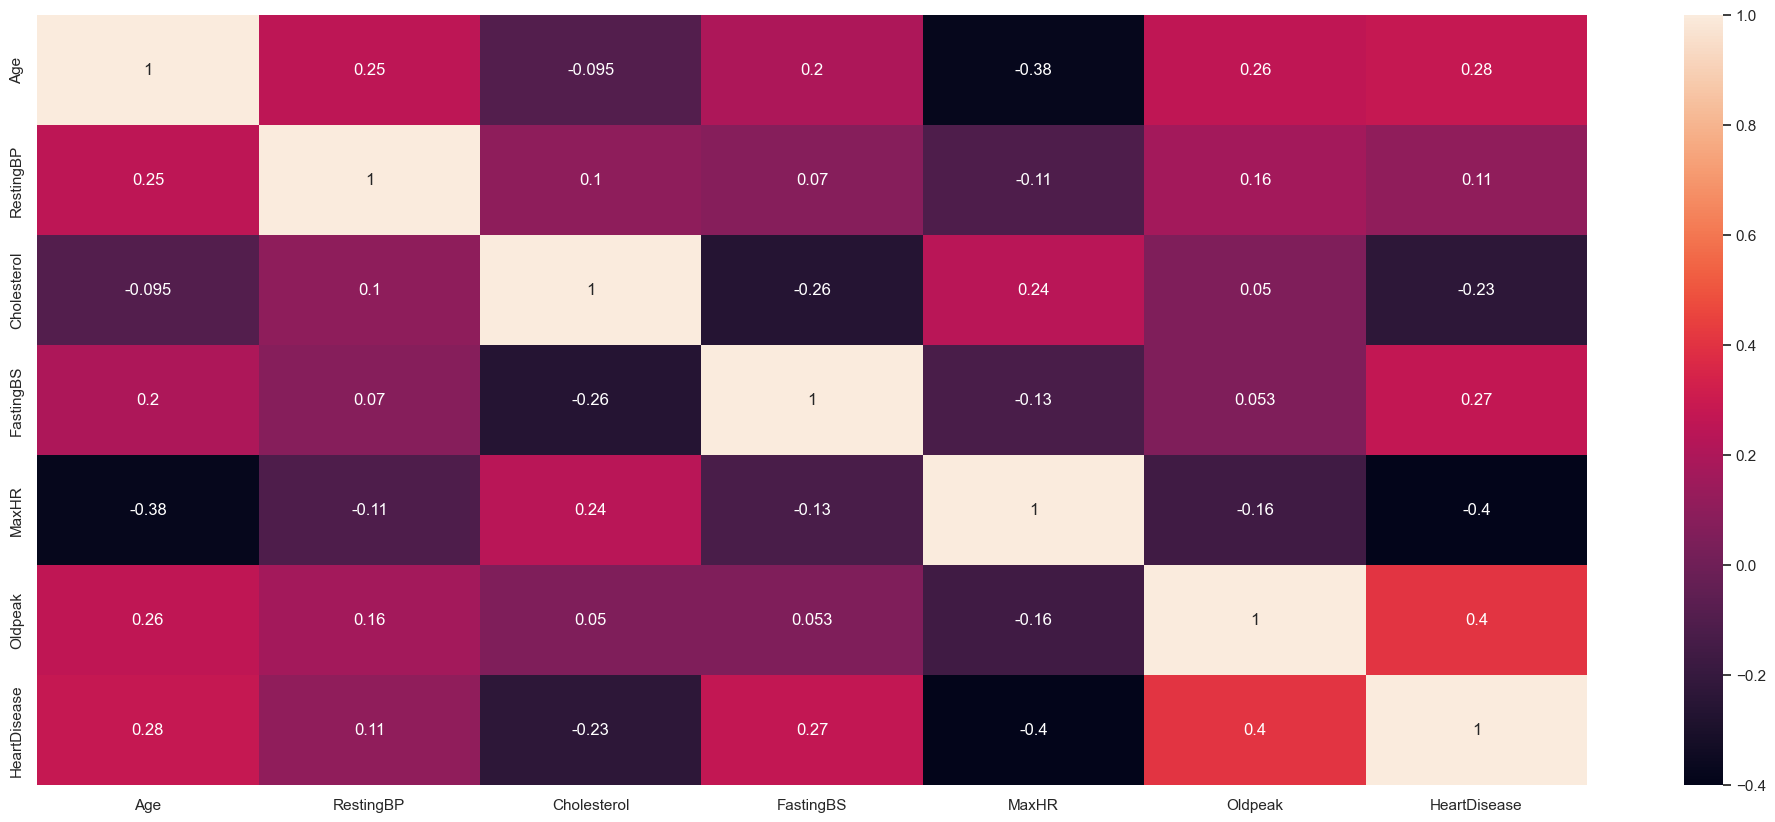

In [16]:
sns.heatmap(data=df2.corr(), annot=True);

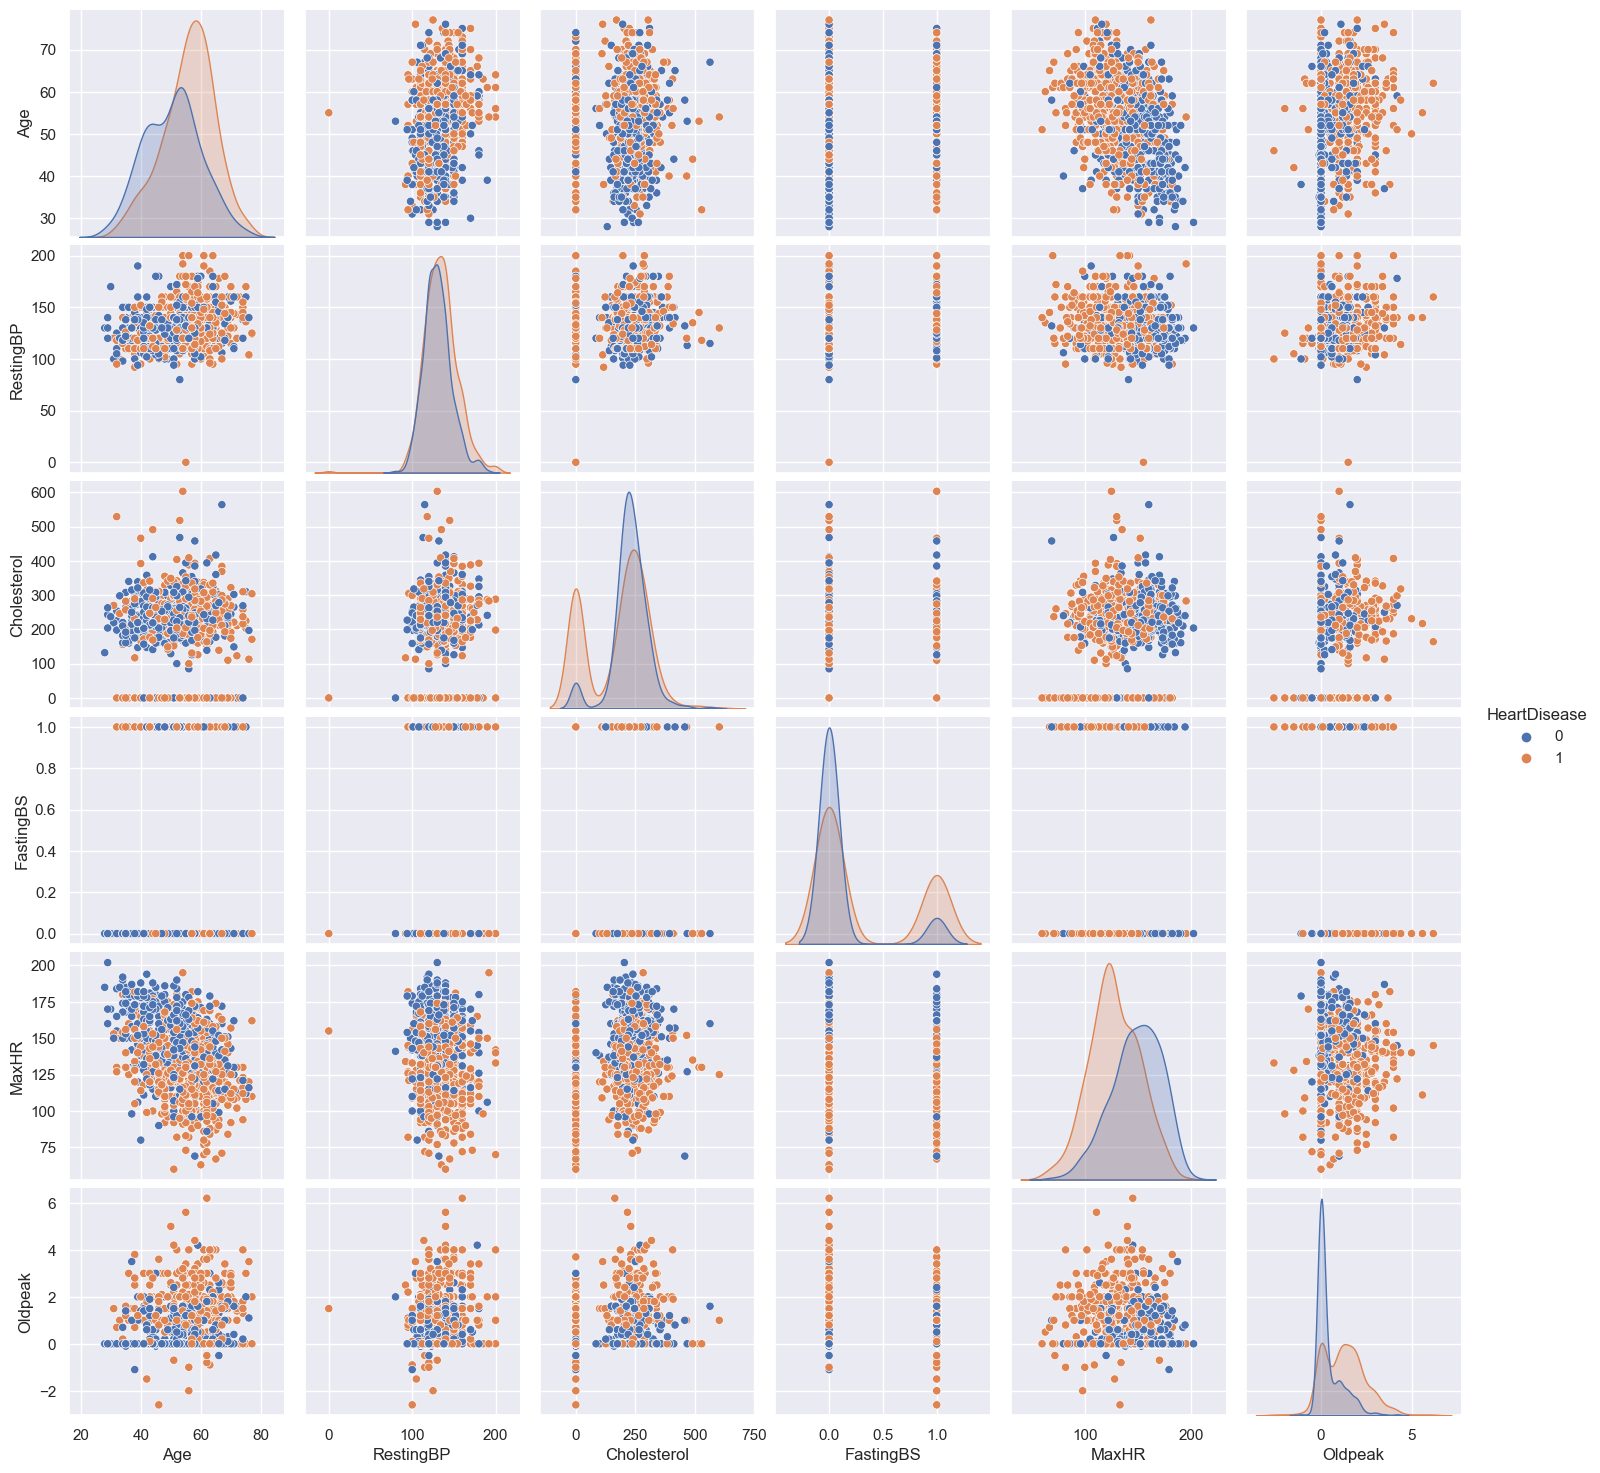

In [17]:
sns.pairplot(num_attributes, hue='HeartDisease');

## 2.2 Categorys analisys

### 2.2.1 Heart Disease and Categorical Features

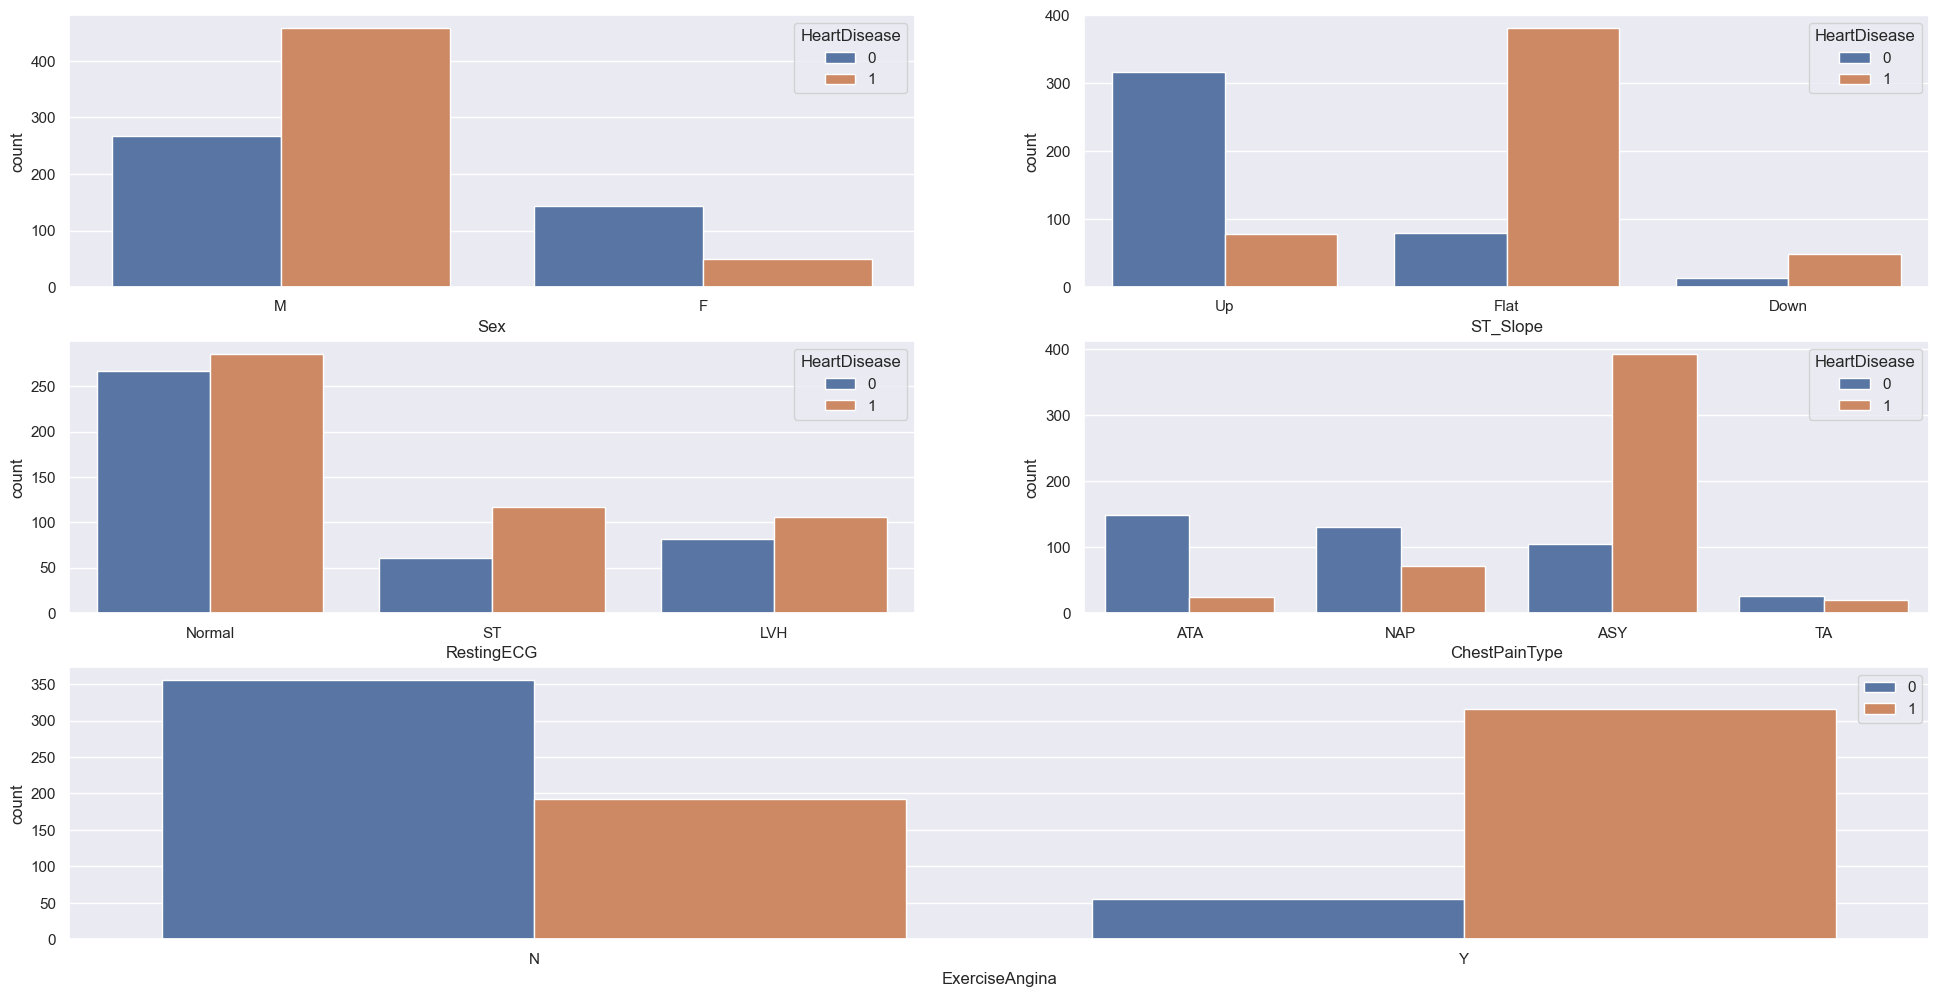

In [18]:
fig = plt.figure(figsize=(24, 12))
spec = gs.GridSpec(ncols = 2, nrows = 3, figure = fig)

ax1 = fig.add_subplot(spec[0,0]) # primeira linha e primeira coluna
ax2 = fig.add_subplot(spec[0,1]) # primeira linha e segunda coluna
ax3 = fig.add_subplot(spec[1,0]) # segunda linha e primeira coluna
ax4 = fig.add_subplot(spec[1,1]) # segunda linha e segunda coluna
ax5 = fig.add_subplot(spec[2,:]) # terceira linha e duas colunas

sns.countplot(x=df2['Sex'], hue=df2['HeartDisease'], ax=ax1);
sns.countplot(x=df2['ST_Slope'], hue=df2['HeartDisease'], ax=ax2);
sns.countplot(x=df2['RestingECG'], hue=df2['HeartDisease'], ax=ax3);
sns.countplot(x=df2['ChestPainType'], hue=df2['HeartDisease'], ax=ax4);
sns.countplot(x=df2['ExerciseAngina'], hue=df2['HeartDisease'], ax=ax5);
plt.legend();

### 2.2.2 Age distribution by sex

In [19]:
cat_attributes.columns

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

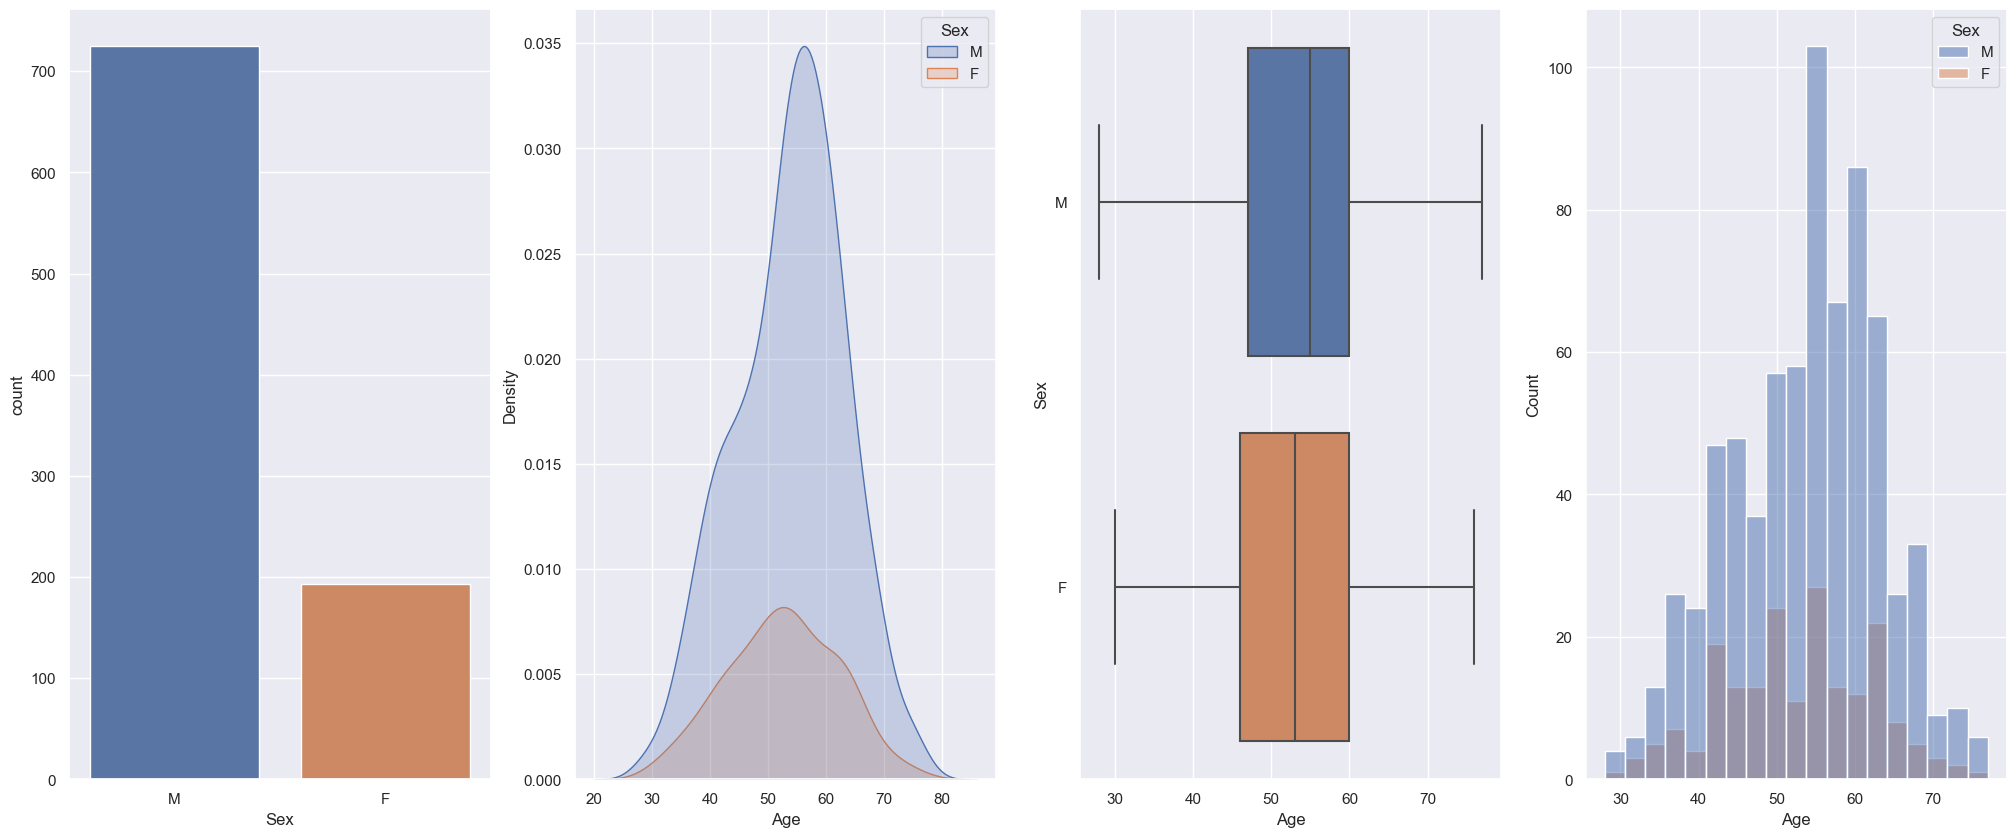

In [20]:
plt.subplot(1, 4, 1)
sns.countplot(x=df2['Sex']);

plt.subplot(1, 4, 2)
sns.kdeplot(data=df2, x='Age', hue='Sex', shade=True);

plt.subplot(1, 4, 3)
sns.boxplot(y='Sex', x='Age', data=df2);

plt.subplot(1, 4, 4)
sns.histplot(x=df2['Age'], hue=df2['Sex']);

### 2.2.3 Chest Pain Type by Sex

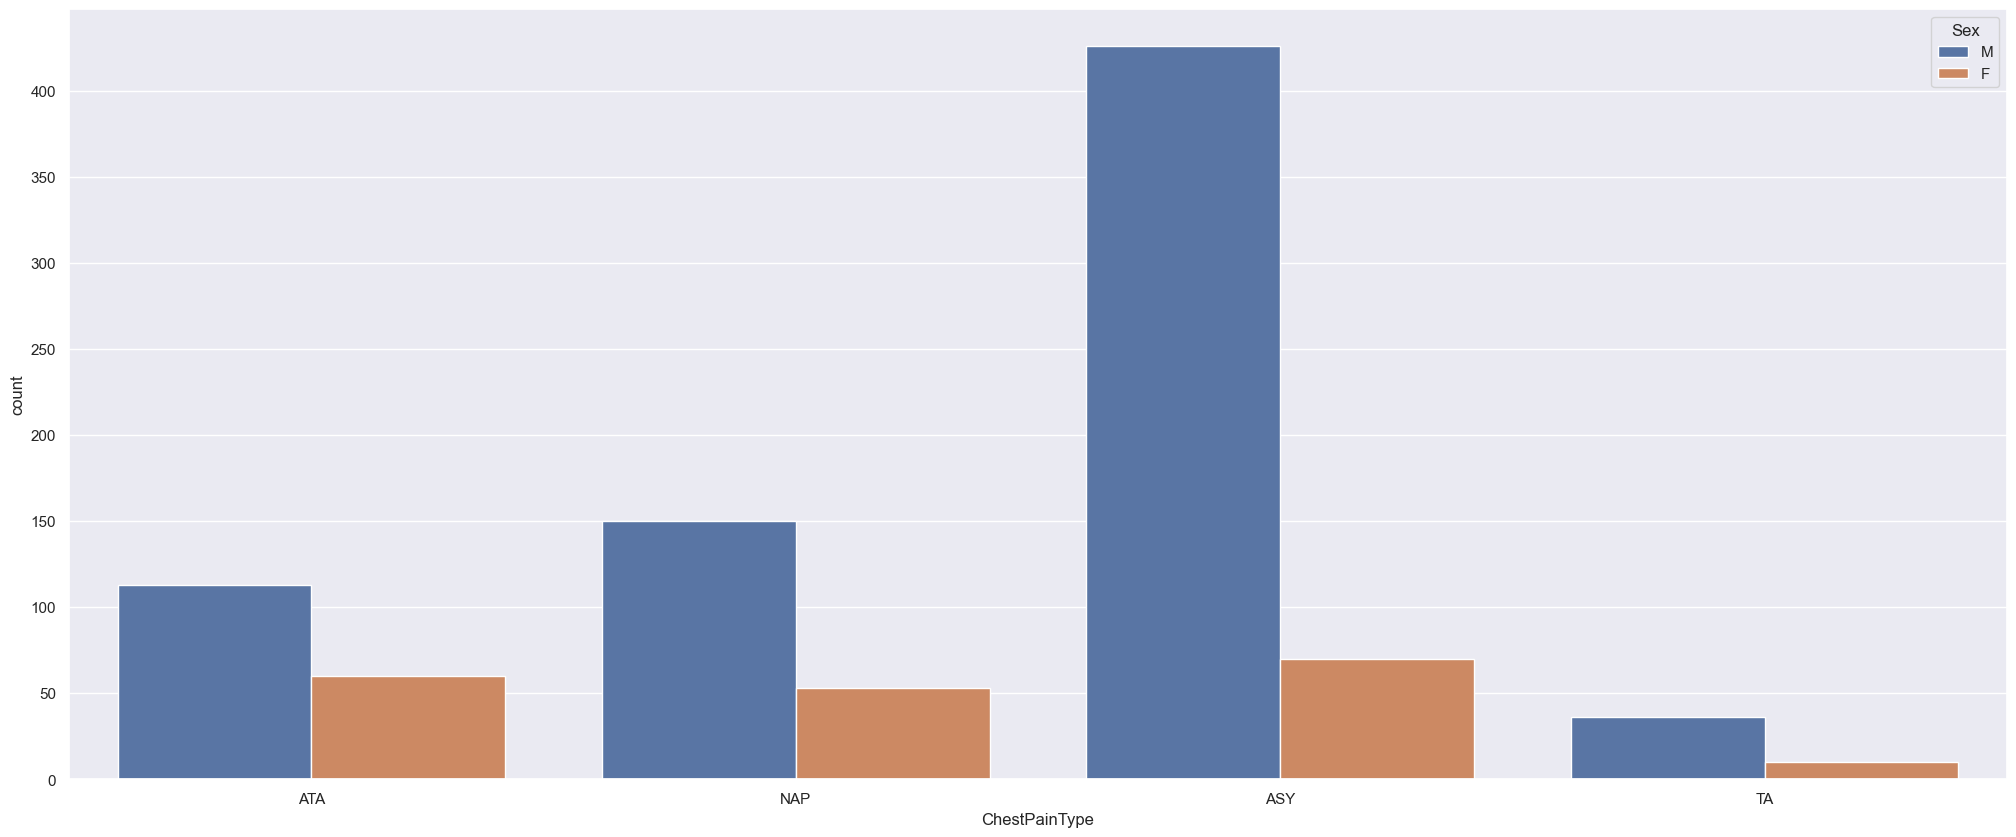

In [21]:
sns.countplot(x=df2['ChestPainType'], hue=df2['Sex']);

### 2.2.4 Max Heart Rate (MaxHR) relations

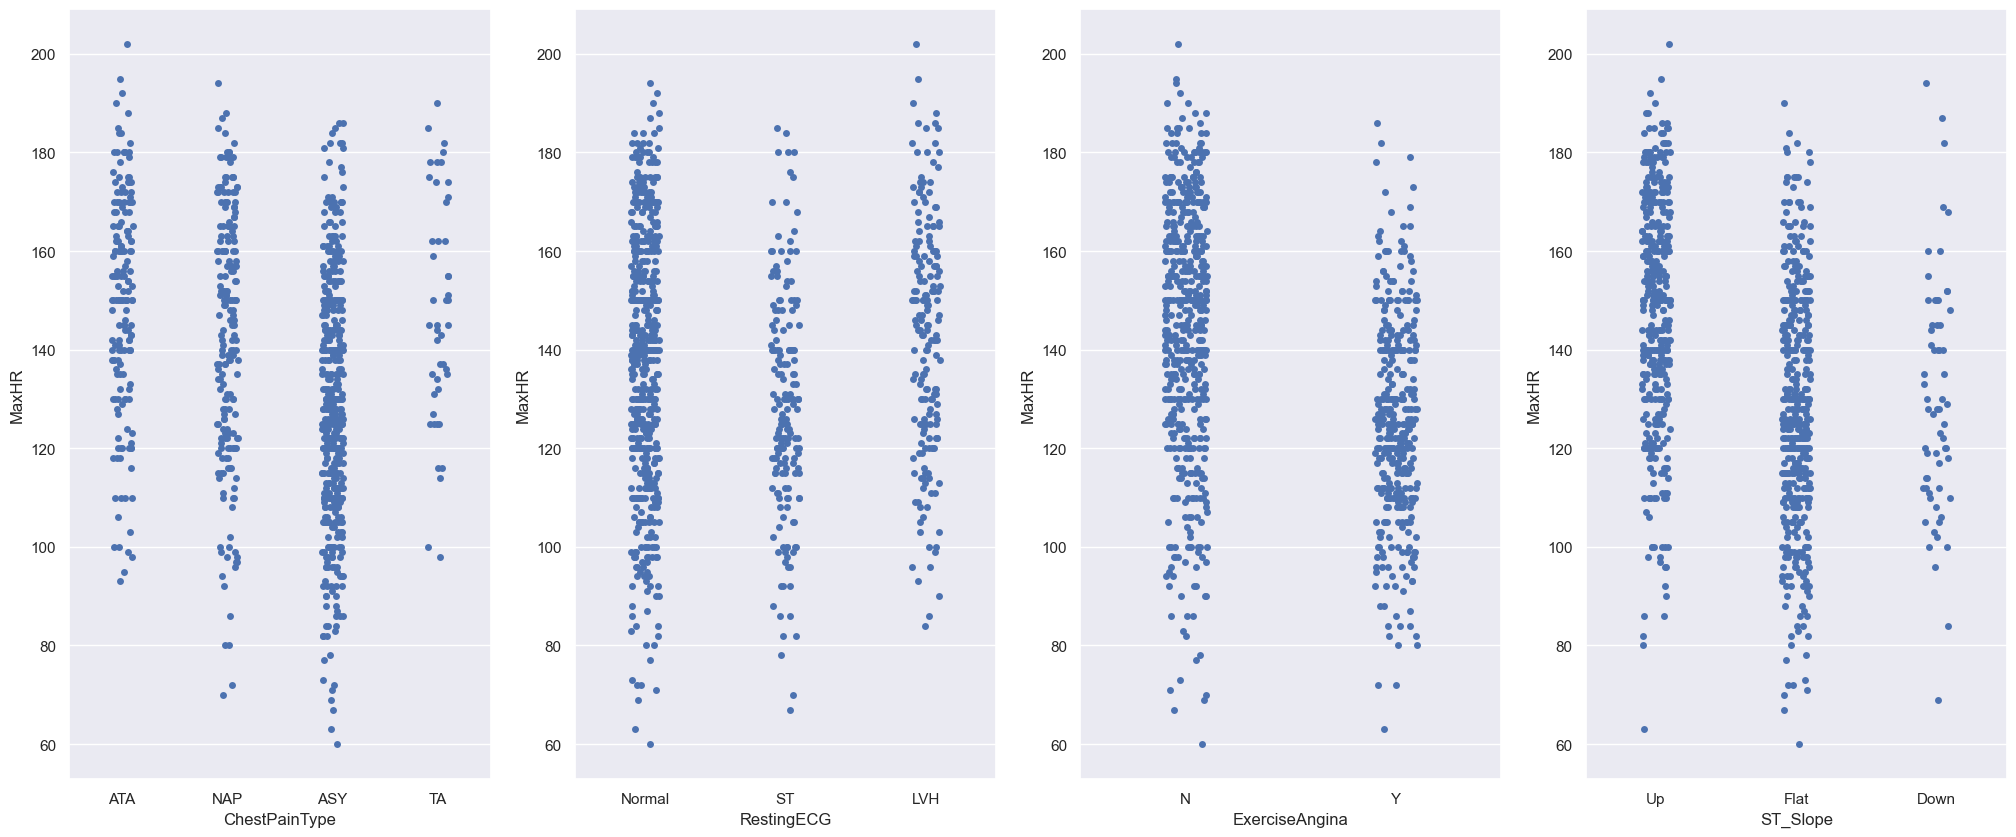

In [22]:
graph2 = df2[['ChestPainType', 'MaxHR']]
plt.subplot(1, 4, 1)
sns.stripplot(x='ChestPainType', y='MaxHR', data=graph2);

graph3 = df2[['RestingECG', 'MaxHR']]
plt.subplot(1, 4, 2)
sns.stripplot(x='RestingECG', y='MaxHR', data=graph3);

graph4 = df2[['ExerciseAngina', 'MaxHR']]
plt.subplot(1, 4, 3)
sns.stripplot(x='ExerciseAngina', y='MaxHR', data=graph4);

graph5 = df2[['ST_Slope', 'MaxHR']]
plt.subplot(1, 4, 4)
sns.stripplot(x='ST_Slope', y='MaxHR', data=graph5);

### 2.2.5 Chest Pain Type e Resting ECG analysis

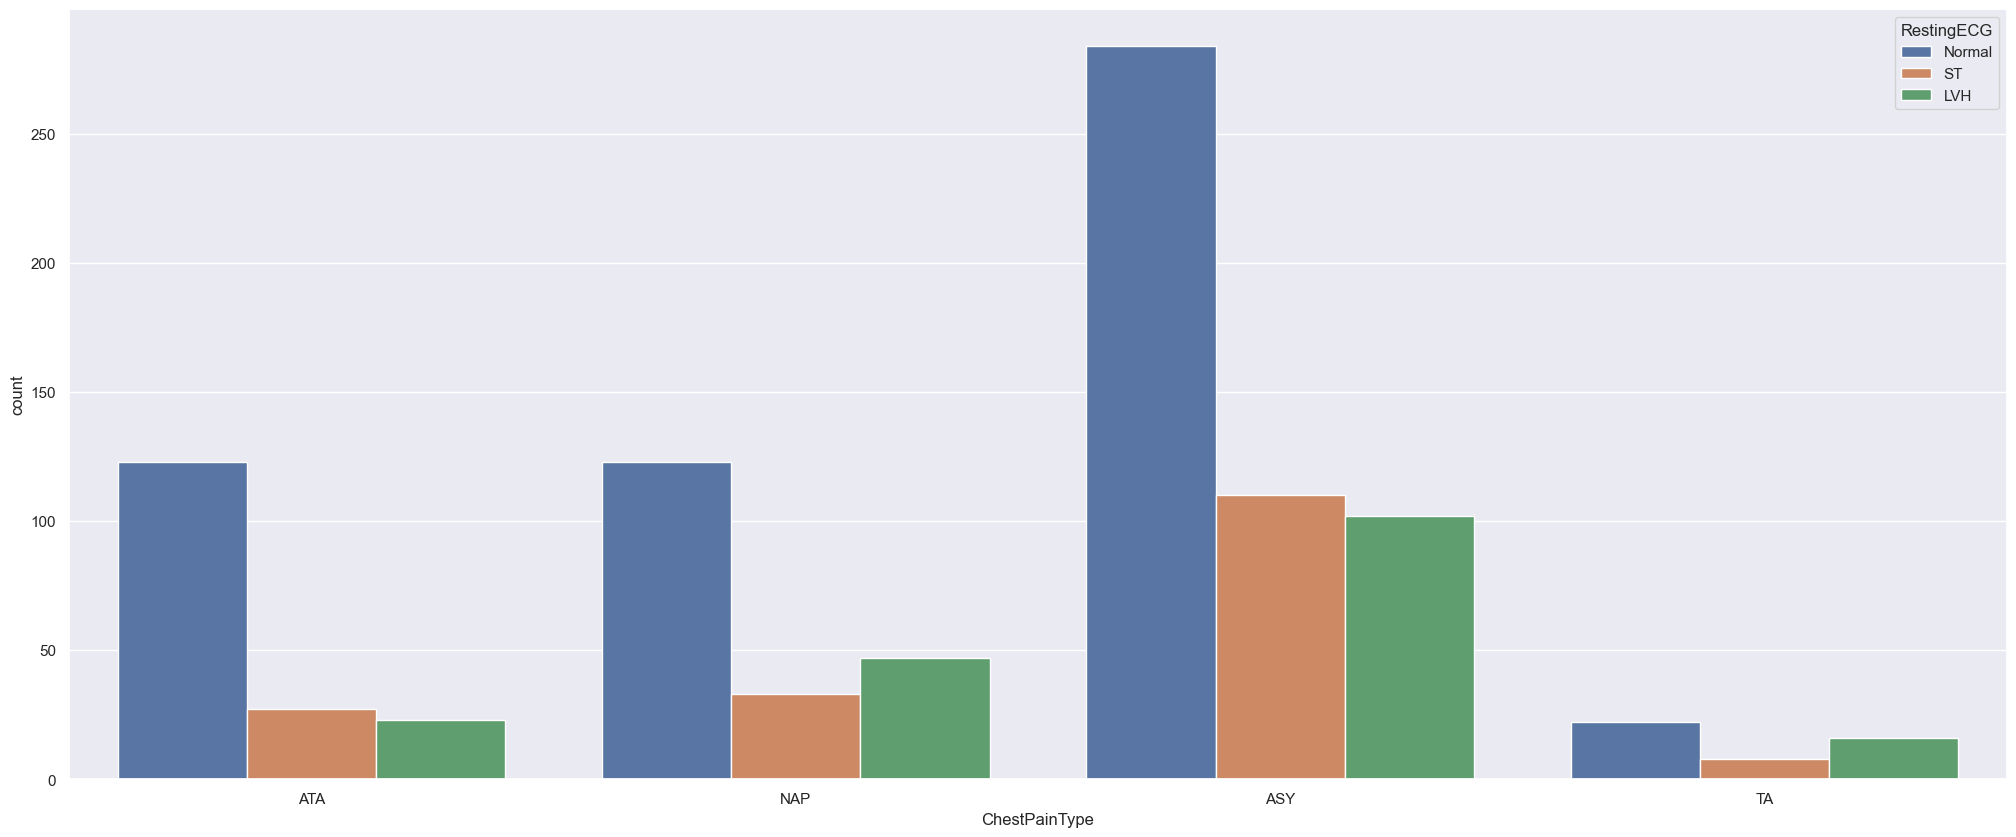

In [23]:
sns.countplot(x=df2['ChestPainType'], hue=df2['RestingECG']);

### 2.2.6 Exercise Angina and ST Slope

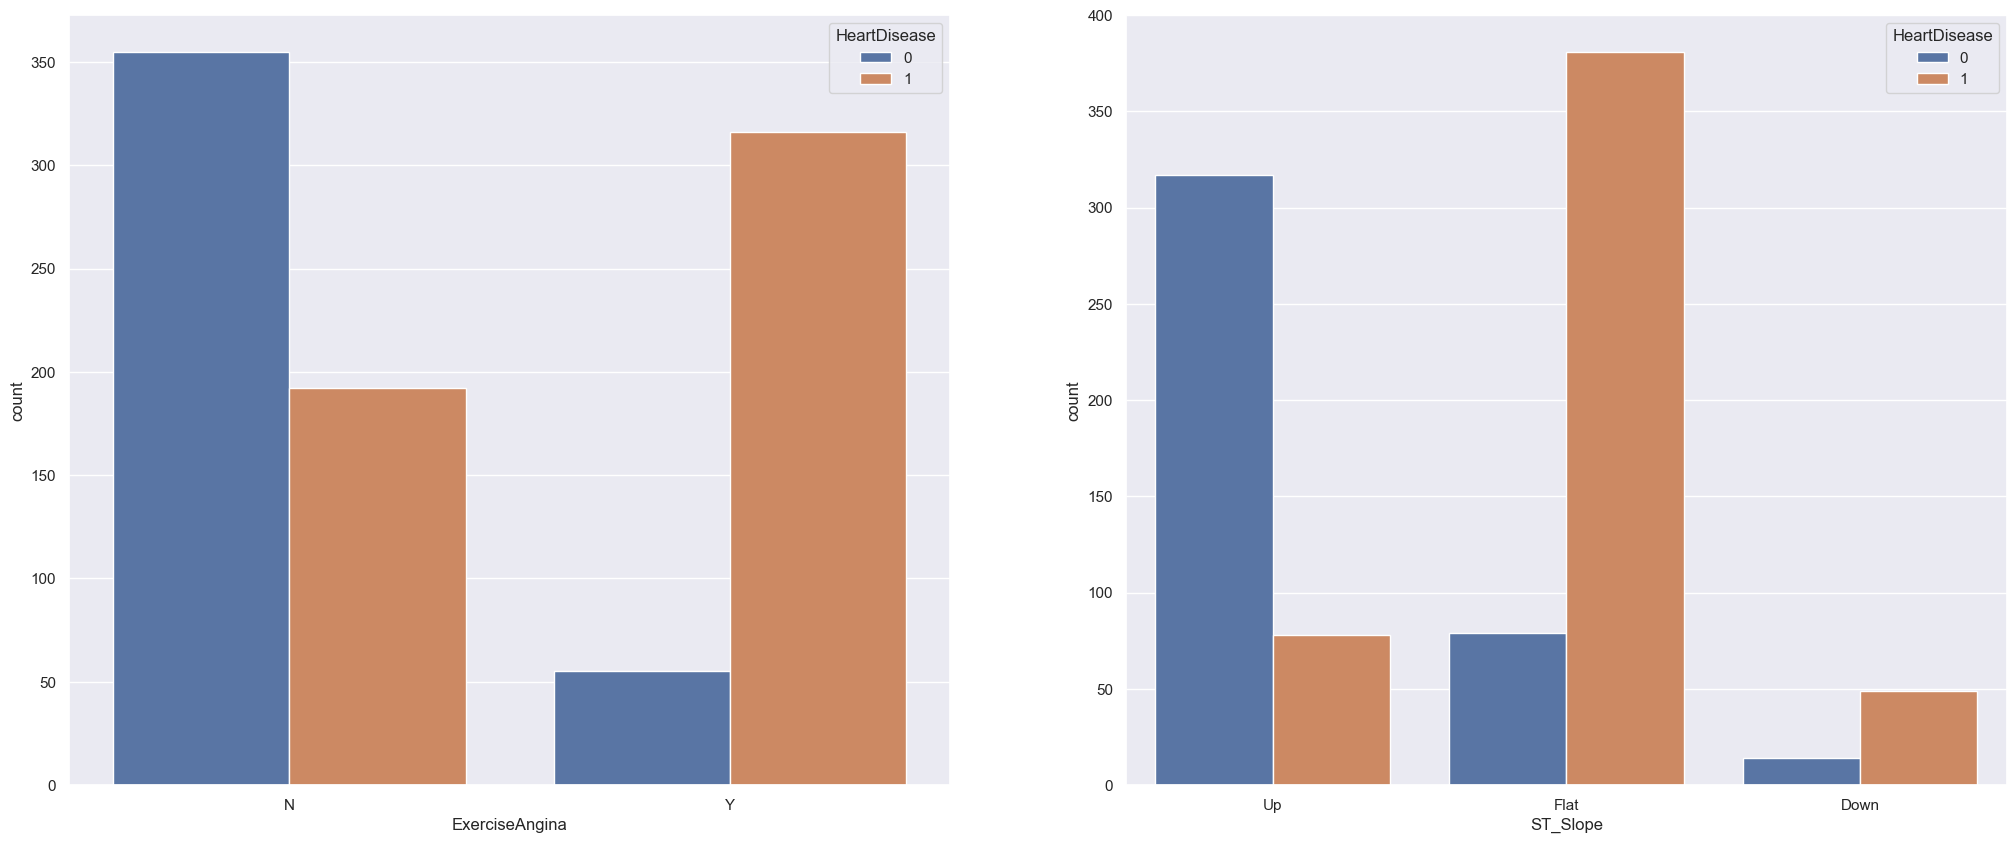

In [24]:
plt.subplot(1, 2, 1)
sns.countplot(x=df2['ExerciseAngina'], hue=df2['HeartDisease']);

plt.subplot(1, 2, 2)
sns.countplot(x=df2['ST_Slope'], hue=df2['HeartDisease']);


# 3.0 DATA PREPARATION

In [25]:
df3 = df2.copy()

In [26]:
df3.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

## 3.1 Dummies

In [27]:
df3 = pd.get_dummies(df3, columns = ['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'Sex'])

In [28]:
df3 = df3.drop(columns=['Sex_F'])

In [29]:
df3.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N',
       'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up',
       'Sex_M'],
      dtype='object')

## 3.2 Train and Test Split

In [30]:
X = df3.drop(columns=['HeartDisease'])
y = df3[['HeartDisease']]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 3.3 Rescaling

In [32]:
sts = preprocessing.StandardScaler()

In [33]:
cols = X_train.columns
cols

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal',
       'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y',
       'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up', 'Sex_M'],
      dtype='object')

In [34]:
X_train = sts.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)
X_test = sts.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

## 3.4 Boruta Selector

In [35]:
X_train_b = X_train.values
y_train_b = y_train.values

In [36]:
# define RandomForestRegressor
rf = RandomForestClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	9
Iteration:

In [37]:
cols_selected = boruta.support_.tolist()

In [39]:
# best features
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['Age',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'ChestPainType_ASY',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'ST_Slope_Flat',
 'ST_Slope_Up']

# 4.0 MACHINE LEARNING MODELLING

In [41]:
X_train = X_train[cols_selected_boruta]
X_test = X_test[cols_selected_boruta]

## 4.1 Decision Tree

In [42]:
decision_tree = DecisionTreeClassifier()

In [43]:
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [44]:
dt_result = decision_tree.predict(X_test)

In [45]:
print(metrics.classification_report(y_test, dt_result))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72       112
           1       0.83      0.76      0.79       164

    accuracy                           0.76       276
   macro avg       0.75      0.76      0.76       276
weighted avg       0.77      0.76      0.76       276



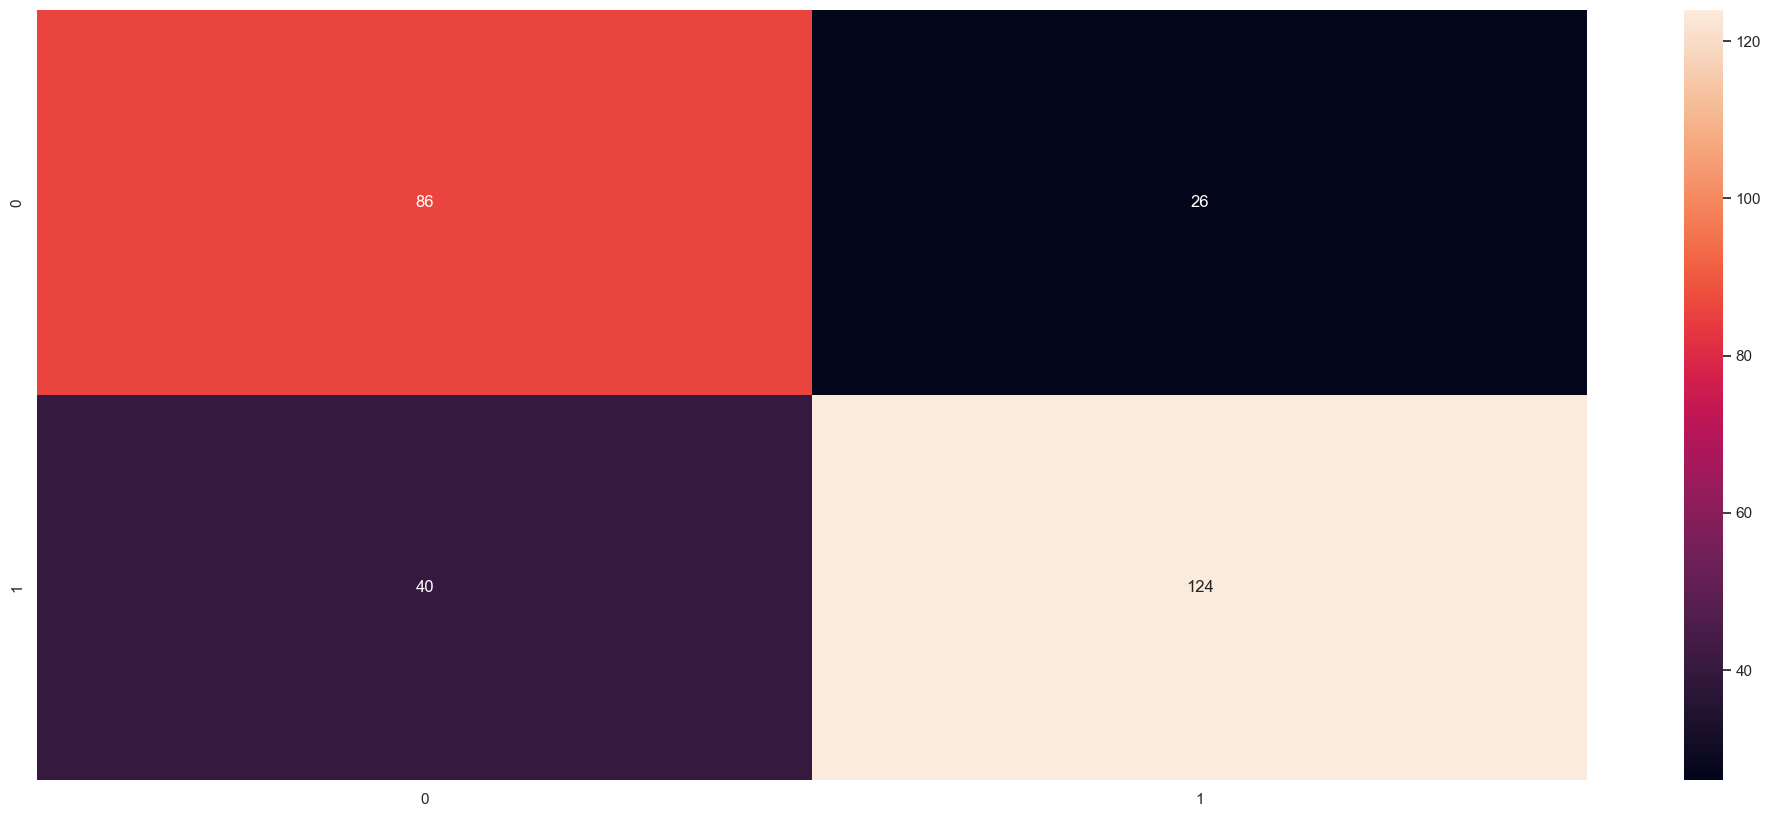

In [46]:
sns.heatmap(metrics.confusion_matrix(y_test, dt_result), annot=True, fmt=".0f");

### 4.1.1 Decision Tree - Cross Validation

In [47]:
dt_scores = cross_val_score(decision_tree, X, y, cv=5, scoring='f1')

In [48]:
dt_result_cv = dt_scores.mean()
dt_result_cv

0.7587011292106769

## 4.2 Random Forest

In [49]:
rf = RandomForestClassifier()

In [50]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [51]:
rf_result = rf.predict(X_test)

In [52]:
print(metrics.classification_report(y_test, rf_result))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       112
           1       0.90      0.87      0.88       164

    accuracy                           0.87       276
   macro avg       0.86      0.87      0.86       276
weighted avg       0.87      0.87      0.87       276



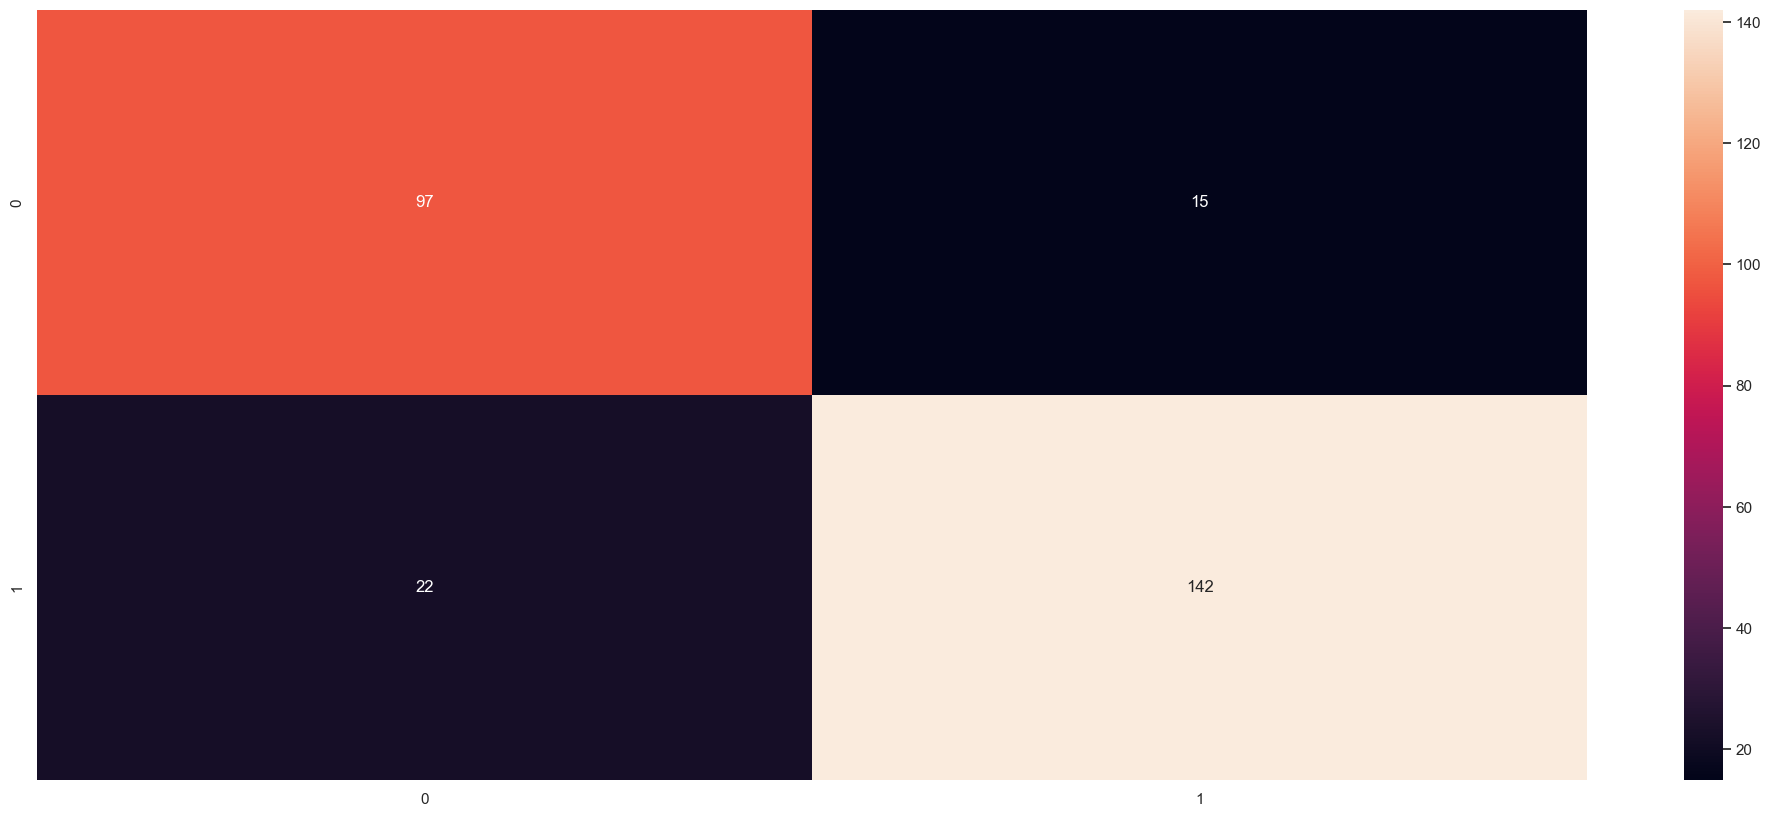

In [53]:
sns.heatmap(metrics.confusion_matrix(y_test, rf_result), annot=True, fmt=".0f");

### 4.2.1 Random Forest - Cross Validation

In [54]:
rf_scores = cross_val_score(rf, X, y, cv=5, scoring='f1')

In [55]:
rf_result_cv = rf_scores.mean()
rf_result_cv

0.8389602027989449

## 4.3 Logistic Regression

In [56]:
lg = LogisticRegression()

In [57]:
lg.fit(X_train, y_train)

LogisticRegression()

In [58]:
lg_result = lg.predict(X_test)

In [59]:
print(metrics.classification_report(y_test, lg_result))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       112
           1       0.91      0.85      0.88       164

    accuracy                           0.86       276
   macro avg       0.86      0.87      0.86       276
weighted avg       0.87      0.86      0.86       276



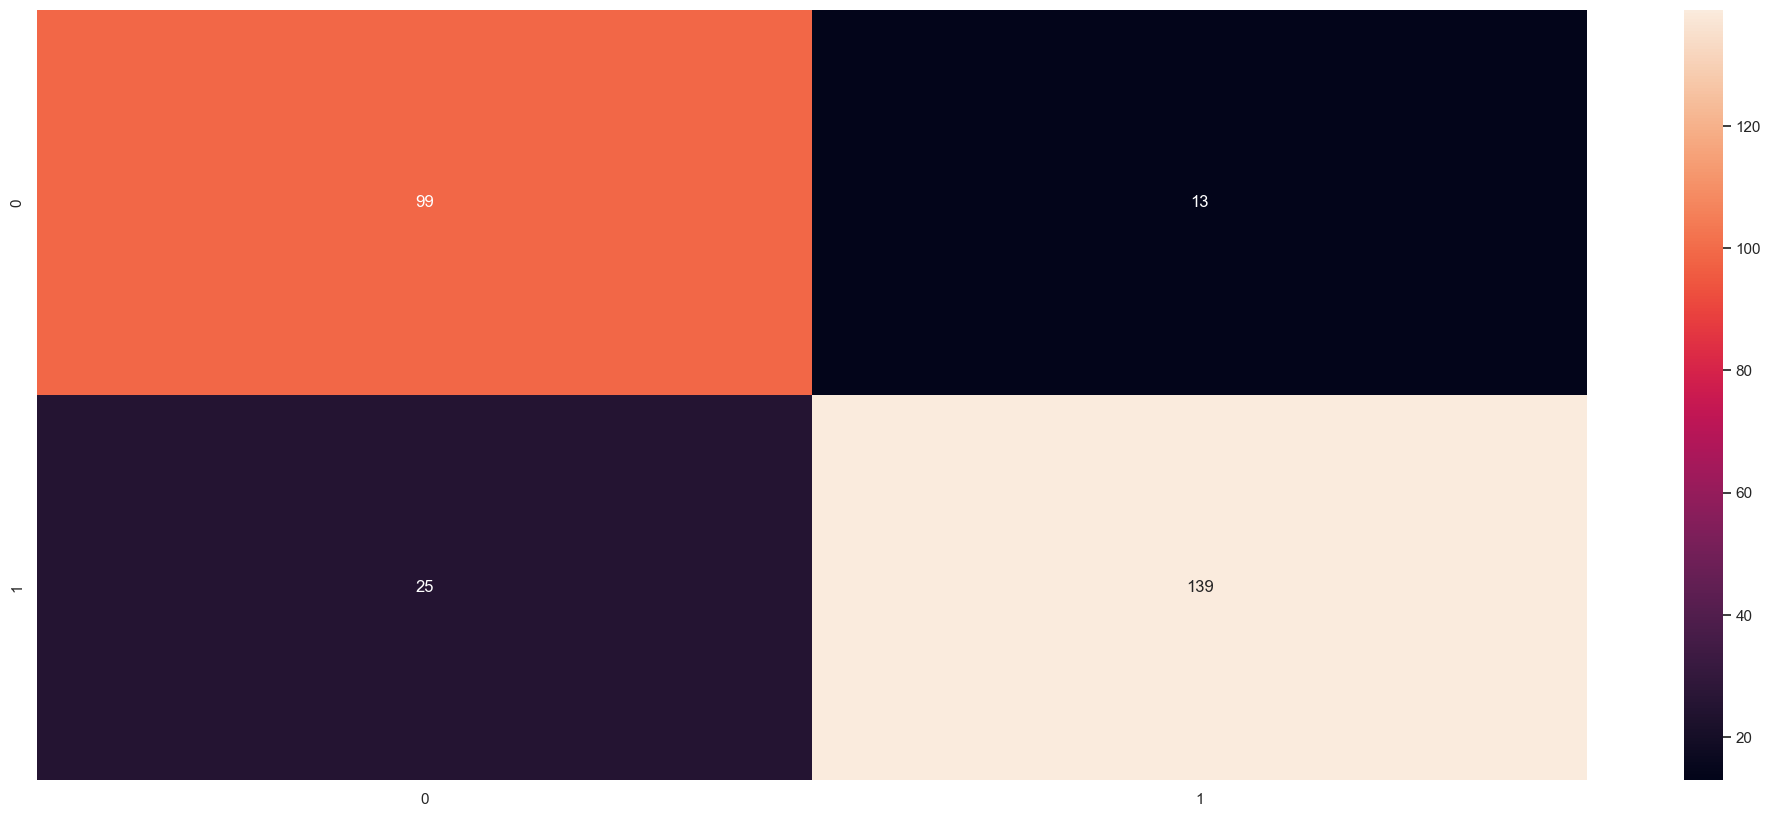

In [60]:
sns.heatmap(metrics.confusion_matrix(y_test, lg_result), annot=True, fmt='.0f');

### 4.3.1 Logistic Regression - Cross Validation

In [61]:
lg_scores = cross_val_score(lg, X, y, cv=5, scoring='f1')

In [62]:
lg_result_cv = lg_scores.mean()
lg_result_cv

0.8492916253529288

## 4.4 XGBoost

In [63]:
xgb = XGBClassifier()

In [64]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [65]:
xgb_result = xgb.predict(X_test)

In [66]:
print(metrics.classification_report(y_test, xgb_result))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       112
           1       0.88      0.80      0.84       164

    accuracy                           0.82       276
   macro avg       0.81      0.82      0.82       276
weighted avg       0.83      0.82      0.82       276



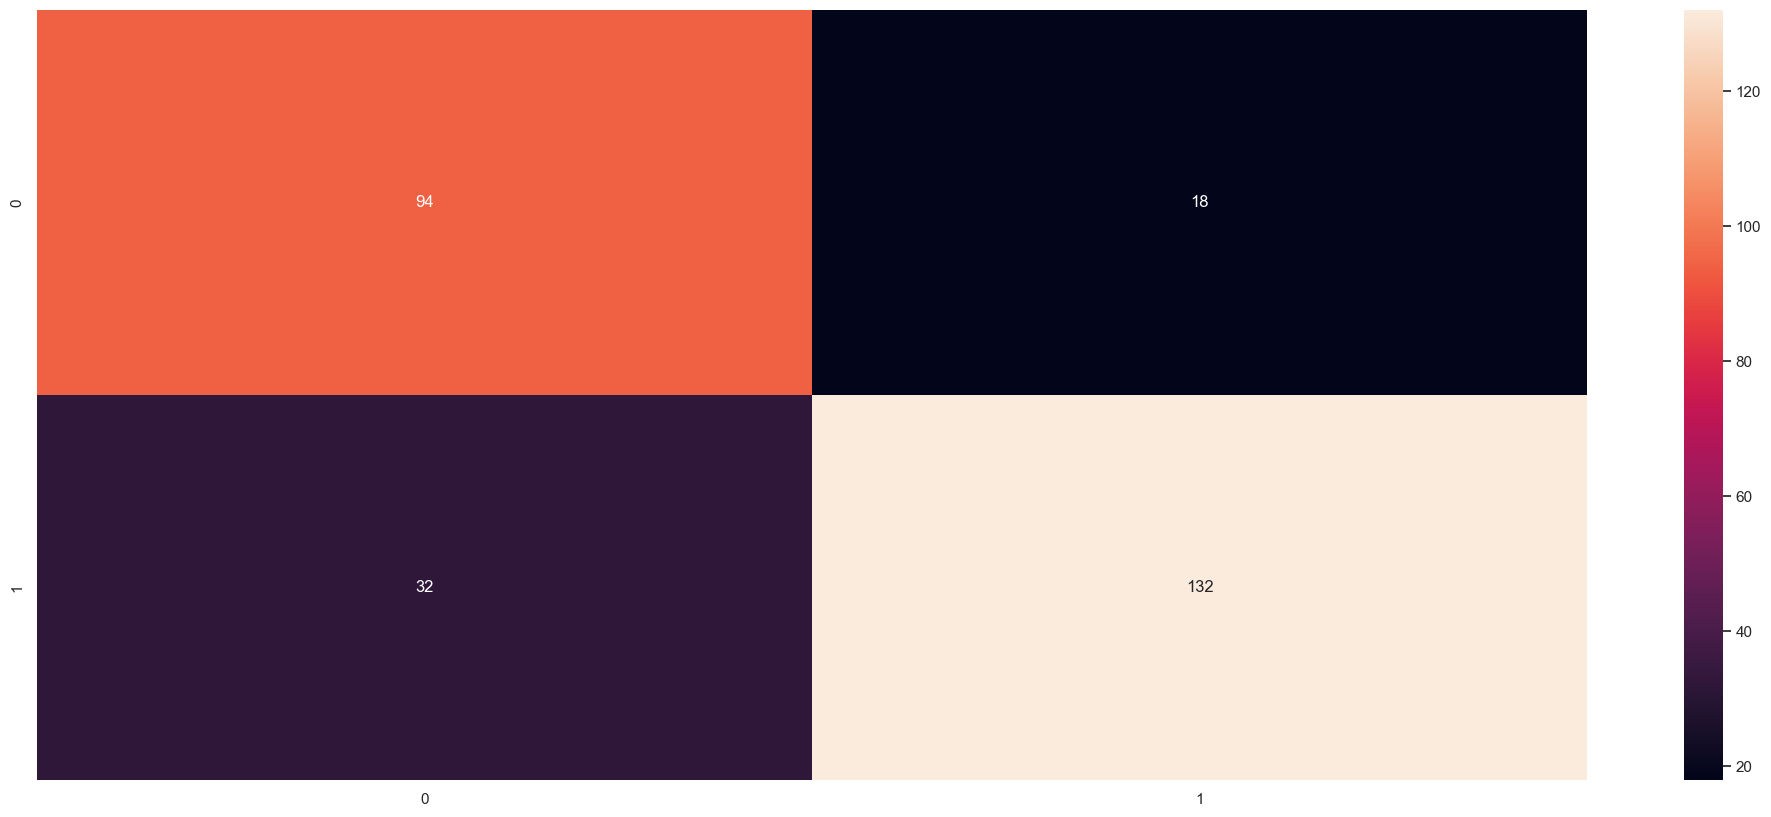

In [67]:
sns.heatmap(metrics.confusion_matrix(y_test, xgb_result), annot=True, fmt='.0f');

### 4.4.1 XGBoost - Cross Validation

In [68]:
xgb_scores = cross_val_score(xgb, X, y, cv=5, scoring='f1')

In [69]:
xgb_result_cv = xgb_scores.mean()
xgb_result_cv

0.8345314981264835

## 4.5 SVM

In [70]:
svm_clf = svm.SVC()

In [71]:
svm_clf.fit(X_train, y_train)

SVC()

In [72]:
svm_result = svm_clf.predict(X_test)

In [73]:
print(metrics.classification_report(y_test, svm_result))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       112
           1       0.89      0.87      0.88       164

    accuracy                           0.86       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.86      0.86      0.86       276



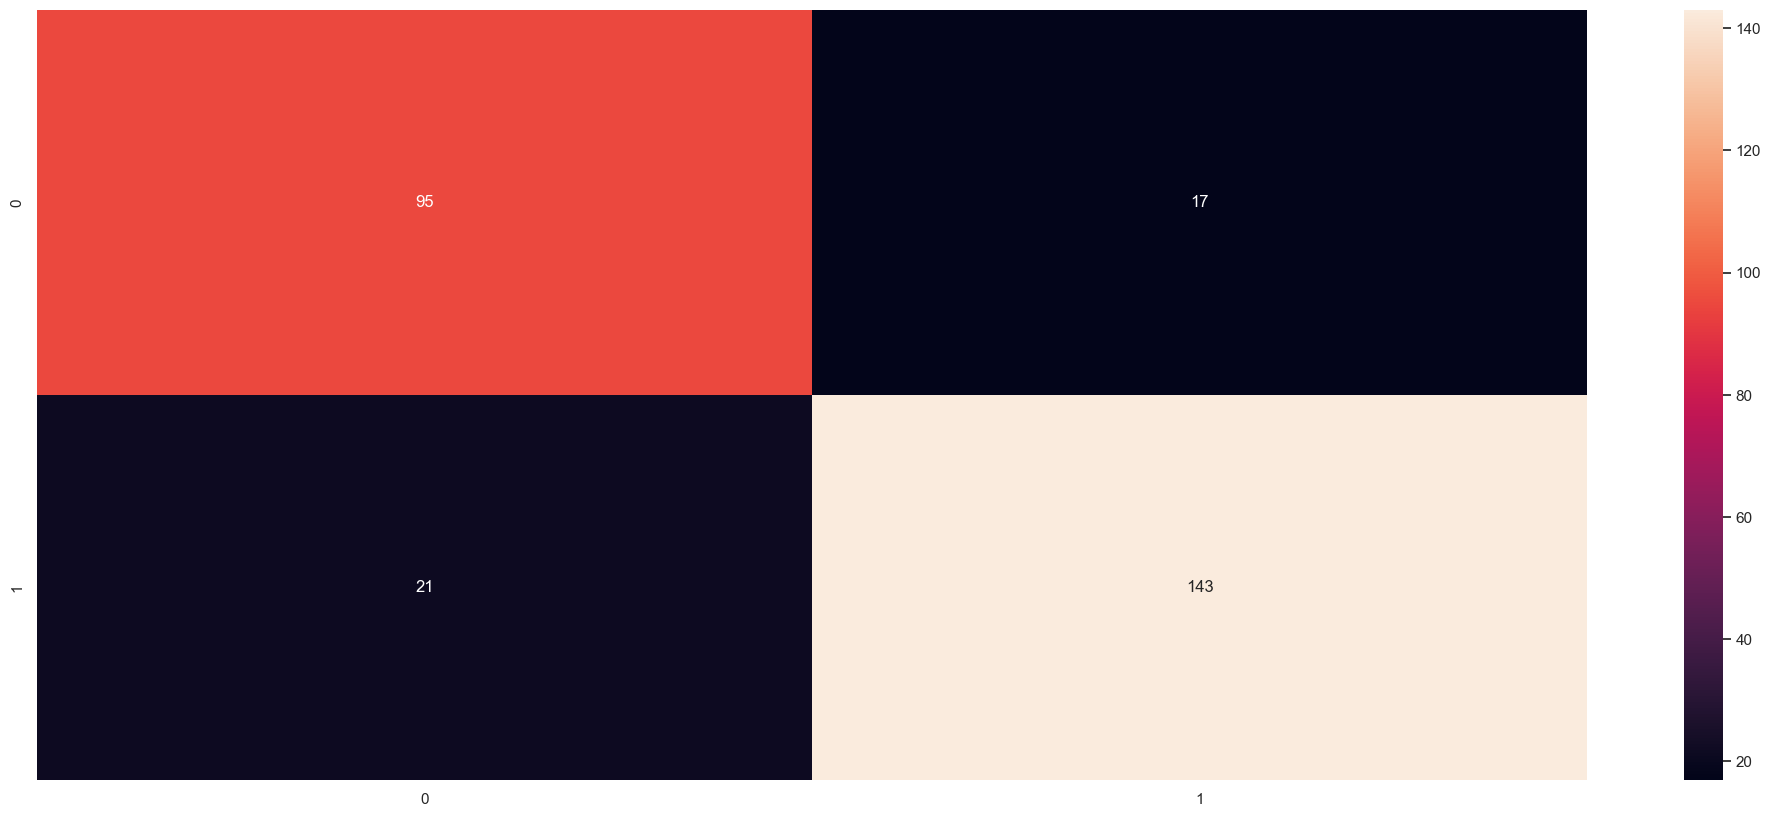

In [74]:
sns.heatmap(metrics.confusion_matrix(y_test, svm_result), annot=True, fmt='.0f');

### 4.5.1 SVM - Cross Validation

In [75]:
svm_scores = cross_val_score(svm_clf, X, y, cv=5, scoring='f1')

In [76]:
svm_result_cv = svm_scores.mean()
svm_result_cv

0.6874752343826185

## 4.6 KNN

In [77]:
knn_clf = KNeighborsClassifier(n_neighbors=3)

In [78]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [79]:
knn_result = knn_clf.predict(X_test)

In [80]:
print(metrics.classification_report(y_test, knn_result))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       112
           1       0.93      0.82      0.87       164

    accuracy                           0.86       276
   macro avg       0.85      0.87      0.86       276
weighted avg       0.87      0.86      0.86       276



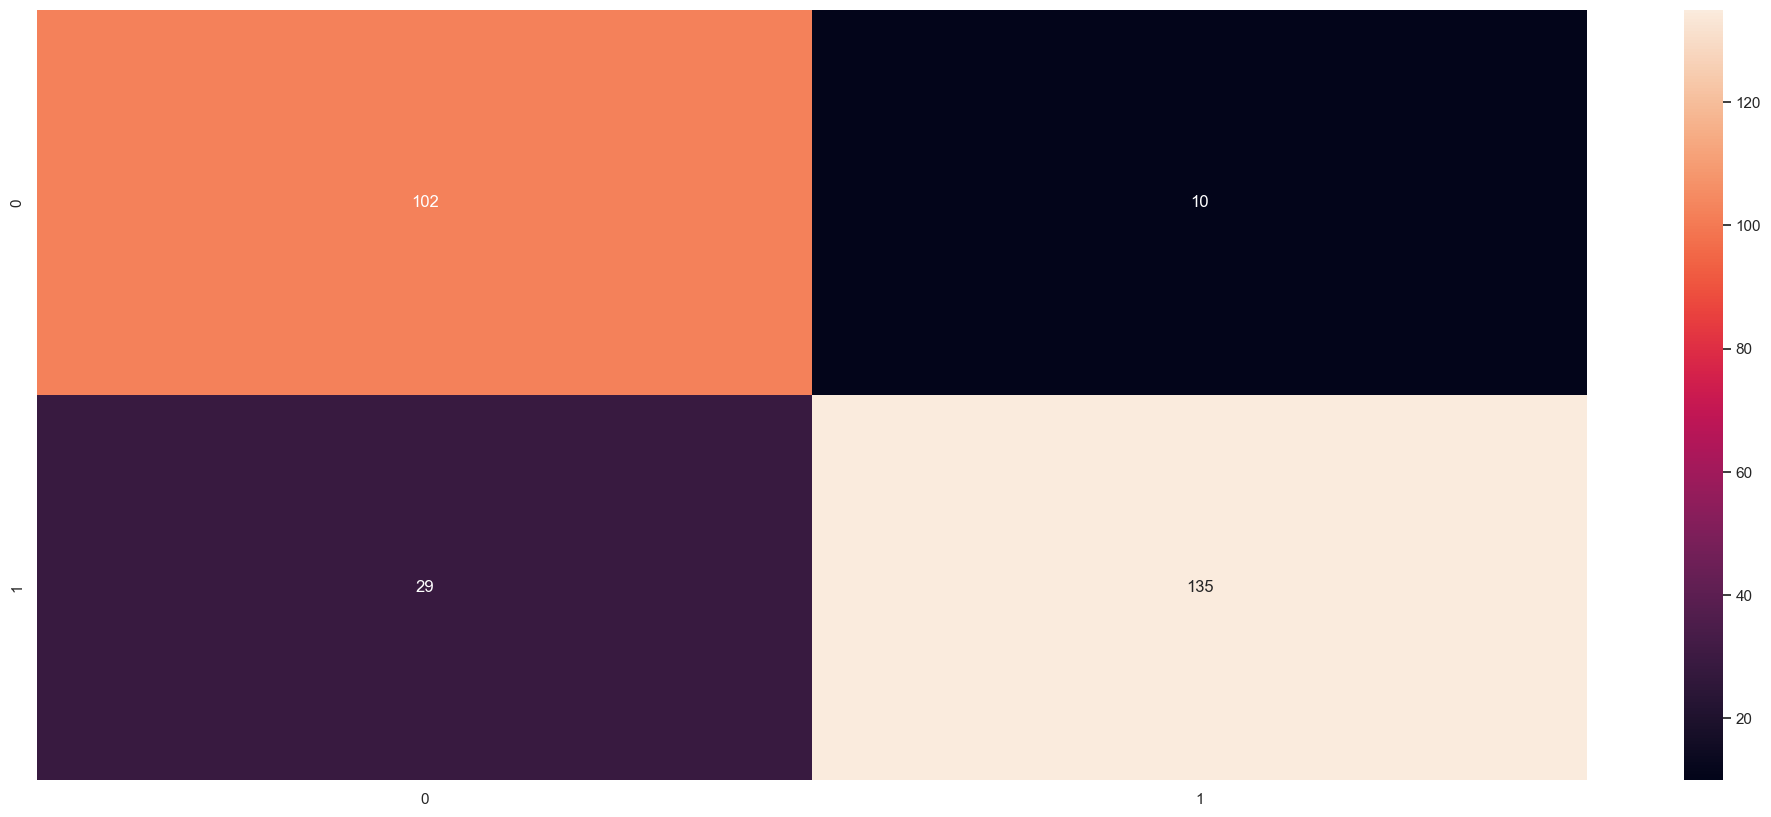

In [81]:
sns.heatmap(metrics.confusion_matrix(y_test, knn_result), annot=True, fmt='.0f');

### 4.6.1 KNN - Cross Validation

In [82]:
knn_scores = cross_val_score(knn_clf, X, y, cv=5, scoring='f1')

In [83]:
knn_result_cv = knn_scores.mean()
knn_result_cv

0.6745982214947106

## 4.7 Model Comparison - Cross Validation

In [84]:
result_dict = {
                'Decision Tree': dt_result_cv,
                'Random Forest': rf_result_cv,
                'Logistic Regression': lg_result_cv,
                'XGBoost': xgb_result_cv,
                'SVM': svm_result_cv,
                'KNN': knn_result_cv
                }

In [85]:
table = pd.DataFrame([result_dict]).T.sort_values(by=0, ascending=False)
table.columns = ['f1_score']
table

,f1_score
Logistic Regression,0.849292
Random Forest,0.838960
XGBoost,0.834531
Decision Tree,0.758701
SVM,0.687475
KNN,0.674598


### 4.7.1 Learning Curve - Logistic Regression

In [88]:
X_lc = X[cols_selected_boruta]

In [89]:
train_sizes, train_scores, test_scores = learning_curve(lg, X_lc, y, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 15), scoring='f1')

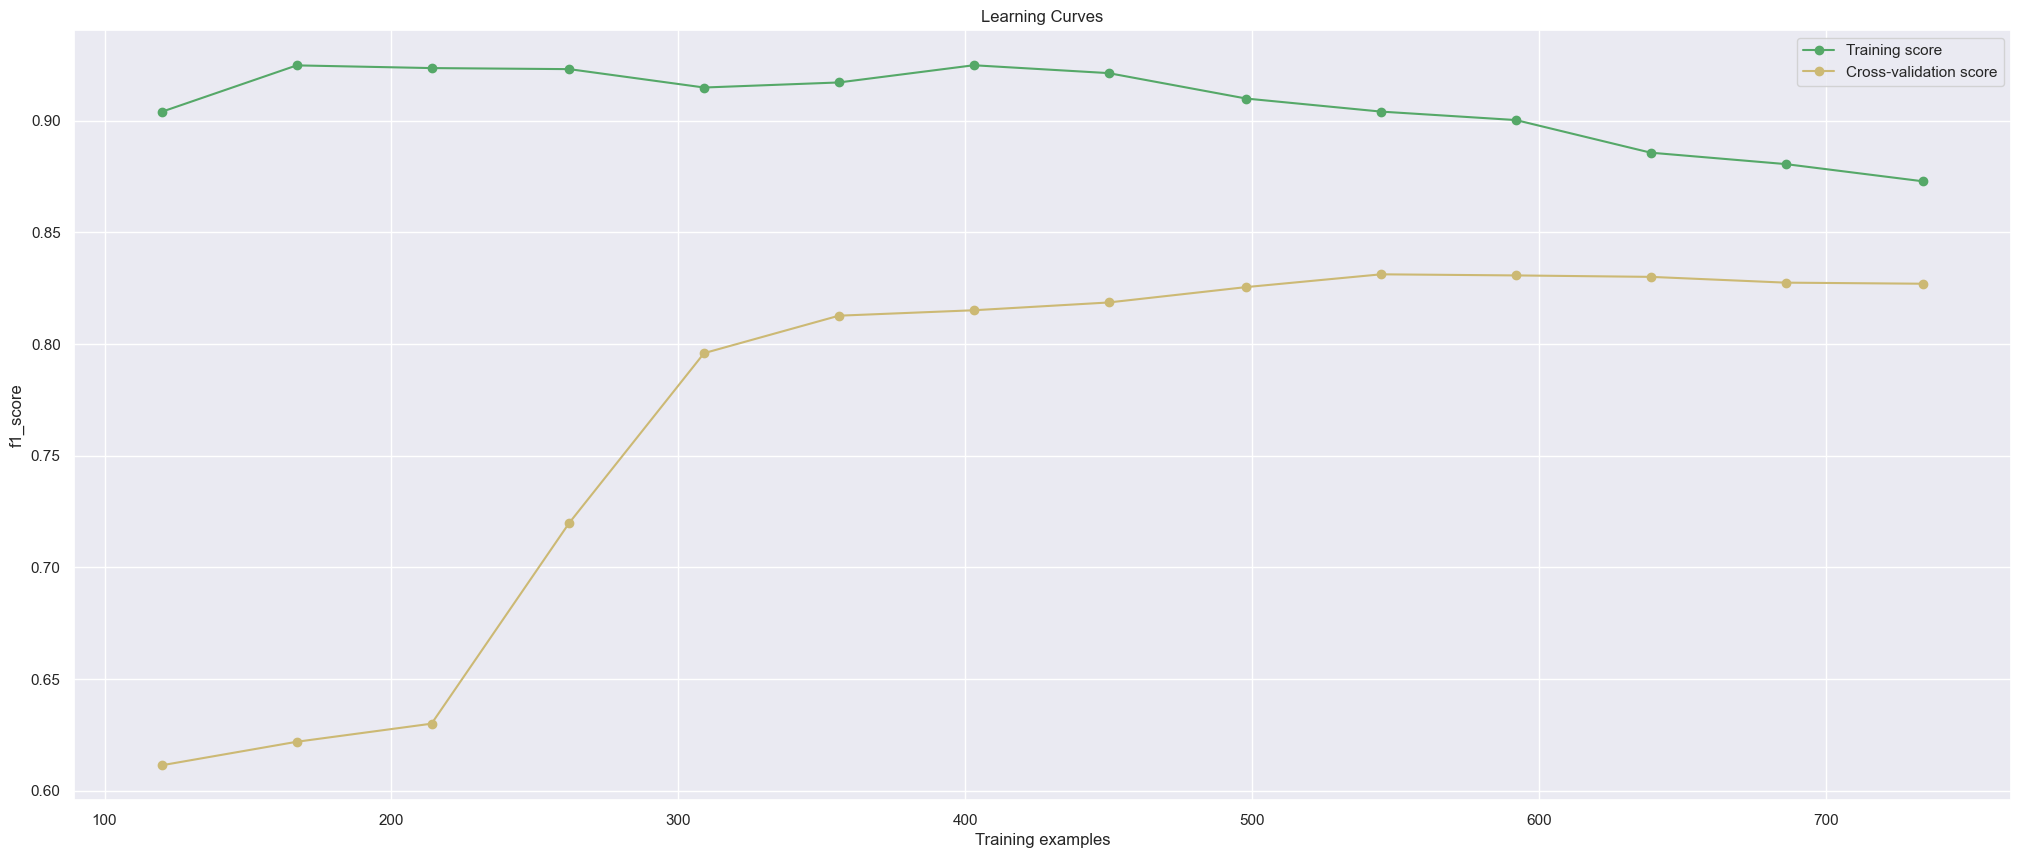

In [90]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid

plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('f1_score')

plt.plot(train_sizes, train_scores_mean, 'o-', color='g', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='y', label='Cross-validation score')

plt.legend(loc='best')
plt.show()

A curva de aprendizagem foi plotada com o intuito de identificar um possível viés do modelo. A curva verde (dados de treinamento) apresenta alto f1_score, mesmo com o aumento de instâncias treinadas, mas ainda sim com uma tendência de queda, o que demonstra uma boa variabilidade de dados, o que nos garante uma menor possibilidade de overfitting. Por outro lado, a curva amarela (cross-validation), apresenta uma tendência de convergência para os dados de treinamento, o que demonstra uma boa capacidade de generalização do modelo. Há ainda um gap entre as duas curvas, o que mostra que ainda existe oportunidade de melhora, através de técnicas de tunning, feature enginnering ou o uso de mais dados de treinamento.

# 5.0 HYPERPARAMETER FINE TUNING

In [81]:
param = {'penalty': ['None', 'l2', 'l1', 'elasticnet'],
         'C': [0, 0.5, 0.8, 1.0],
         'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
        }

In [82]:
gd_search = GridSearchCV(lg, param, cv=5, scoring='f1', verbose=True)

In [83]:
gd_search.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0, 0.5, 0.8, 1.0],
                         'penalty': ['None', 'l2', 'l1', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='f1', verbose=True)

In [84]:
best_params = gd_search.best_params_
best_result = gd_search.best_score_
print(best_params)
print(best_result)

{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8492916253529288


In [85]:
lg_tuned =  LogisticRegression(penalty='l2', C=1, solver='lbfgs')

In [86]:
lg_tuned.fit(X_train, y_train)

LogisticRegression(C=1)

In [87]:
lg_result_tuned = lg_tuned.predict(X_test)

In [88]:
print(metrics.classification_report(y_test, lg_result_tuned))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       112
           1       0.92      0.86      0.89       164

    accuracy                           0.87       276
   macro avg       0.86      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276



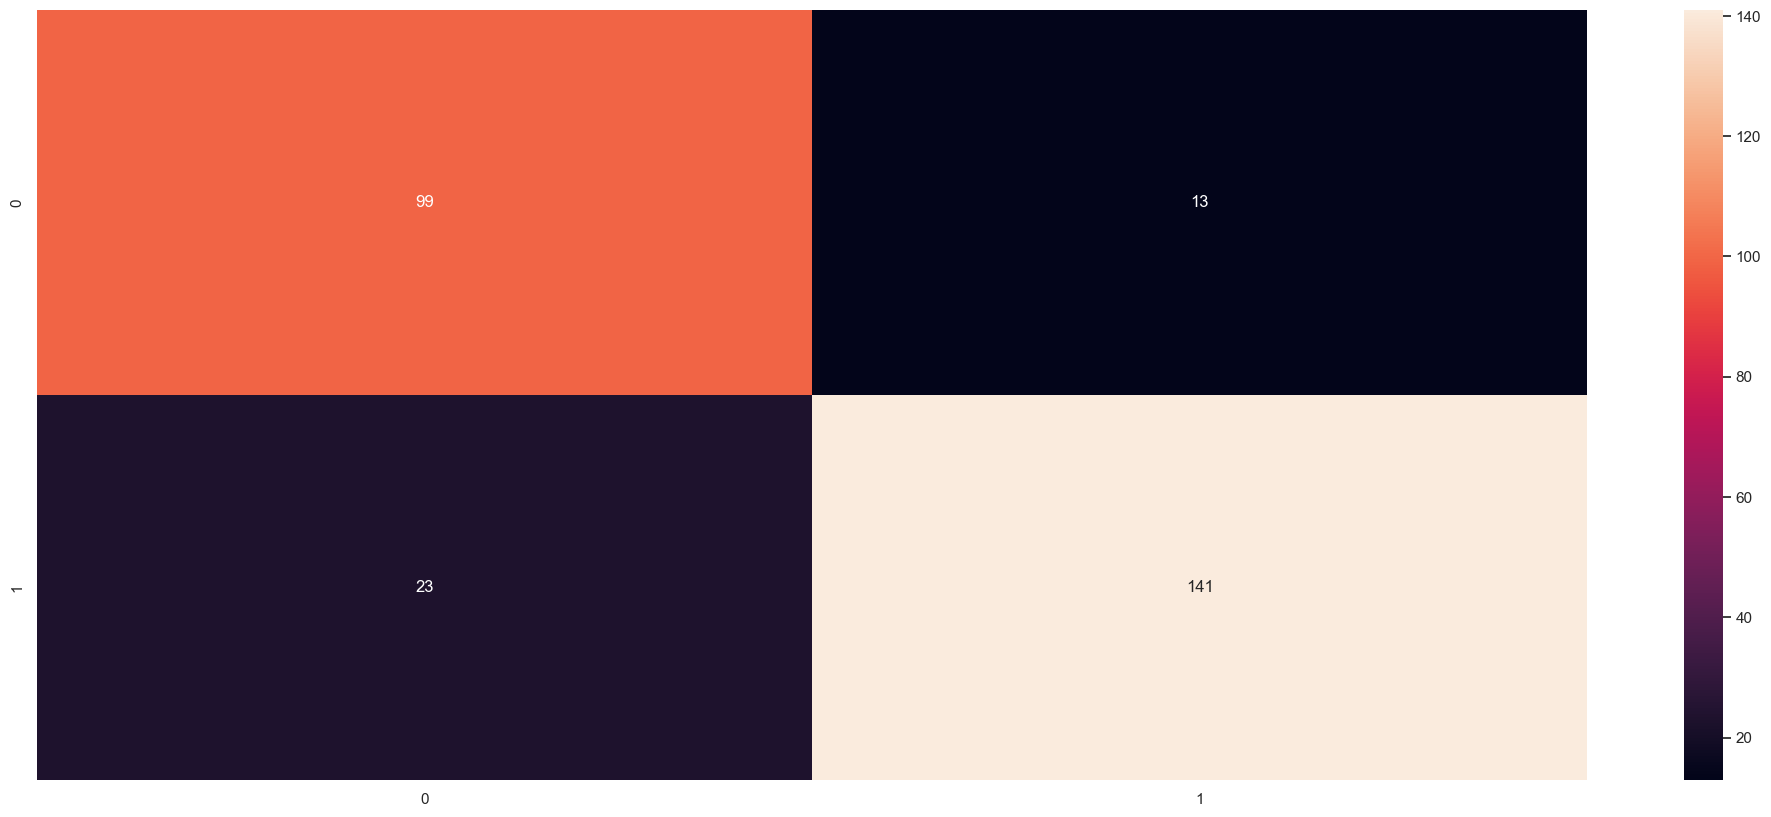

In [89]:
sns.heatmap(metrics.confusion_matrix(y_test, lg_result_tuned), annot=True, fmt='.0f');

In [90]:
lg_scores_tuned = cross_val_score(lg_tuned, X, y, cv=5, scoring='f1')

In [91]:
lg_result_cv_tuned = lg_scores_tuned.mean()
lg_result_cv_tuned

0.8492916253529288